In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

sys.path.append("../")
from src.simul import *

from models import dp_loss as dpl
from models import dp_utils as dpu

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Paths

In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"


## Filter followup subject using Dask dataframe (pandas will crash)

In [3]:
# import dask.dataframe as dd

# # Grab eids with ses-3 data
# freesurfer_df = pd.read_csv(freesurfer_csv,usecols=["eid","26501-3.0"])
# freesurfer_eids = freesurfer_df[~freesurfer_df["26501-3.0"].isna()]["eid"]

# # Read entire CSV using dask
# freesurfer_df = dd.read_csv(freesurfer_csv)
# followup_freesurfer_df = freesurfer_df[freesurfer_df["eid"].isin(freesurfer_eids)].compute()

# # Save filtered df
# followup_freesurfer_df.to_csv(f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv")

## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [4]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


## Read DKT volumes 

In [5]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)
freesurfer_eids = freesurfer_df["eid"].values

freesurfer_df.head()

reading 125 columes


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [6]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = train_df[train_df["eid"].isin(train_eids_avail)].reset_index()

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = test_df[test_df["eid"].isin(test_eids_avail)].reset_index()

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}")

train samples: 2145, freesurfer data available: 1942
test samples: 1057, freesurfer data available: 978


In [17]:
class UKBB_ROI_Dataset(Dataset):
    ''' Simulation dataset
    '''
    def __init__(self, metadata_df, data_csv, pheno_cols_ses2, pheno_cols_ses3, transform=None):
        self.metadata_df = metadata_df
        self.data_csv = data_csv 
        self.pheno_cols_ses2 = pheno_cols_ses2
        self.pheno_cols_ses3 = pheno_cols_ses3
        
    def __len__(self):
        n_samples = len(self.metadata_df)
        return n_samples

    def __getitem__(self, idx):
        _df = self.metadata_df.copy()
        eid = _df.loc[idx,"eid"]
        age_ses2 = _df[_df["eid"]==eid]["age_at_ses2"].values[0]
        age_ses3 = _df[_df["eid"]==eid]["age_at_ses3"].values[0]
        
        usecols = ["eid"] + self.pheno_cols_ses2 + self.pheno_cols_ses3
        data_df = pd.read_csv(self.data_csv, usecols=usecols)
        input1 = data_df[data_df["eid"]==eid][self.pheno_cols_ses2].values
        input2 = data_df[data_df["eid"]==eid][self.pheno_cols_ses3].values
        
        # input1 = np.expand_dims(input1,0)
        # input2 = np.expand_dims(input2,0)

        output1 = age_ses2/100
        output2 = age_ses3/100
        output1 = np.expand_dims(output1,0)
        output2 = np.expand_dims(output2,0)

        # print(input1.shape, output1.shape)

        return (torch.tensor(input1,dtype=torch.float32), torch.tensor(input2,dtype=torch.float32)), \
            (torch.tensor(output1,dtype=torch.float32), torch.tensor(output2,dtype=torch.float32))

## Data-loaders

In [18]:
batch_size = 100

train_dataset = UKBB_ROI_Dataset(train_df, freesurfer_csv, pheno_cols_ses2, pheno_cols_ses3, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = UKBB_ROI_Dataset(test_df, freesurfer_csv, pheno_cols_ses2, pheno_cols_ses3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# iter(train_dataloader).next()

## CUDA

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

## Train model 

In [20]:
n_epochs = 1
input_size = len(pheno_cols_ses2)
hidden_size = 10
lr = 0.001

model = LSN(input_size,hidden_size=hidden_size) # alternative toy model: LSN()
model.train()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
criterion = nn.MSELoss()                        

model, batch_loss_df, epoch_loss_df = train(model,test_dataloader,optimizer,criterion,n_epochs)

x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([100, 1, 10]), torch.Size([100, 1, 10])
concat shape: torch.Size([100, 1, 20])
x1,x2 shapes: torch.Size([78, 1, 10]), torch.Size([78, 1, 10])
c

,epoch_loss
0,NaN


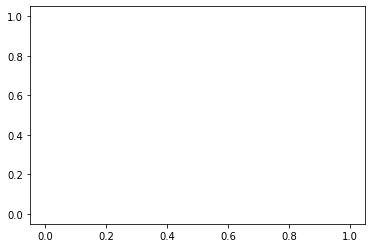

In [21]:
plt.plot(epoch_loss_df)
epoch_loss_df